In [49]:
import sys
sys.path.append('..')
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
import scipy.stats
import utils.plot
import val
from sklearn.decomposition import PCA

import anndata as ann

import umap
import networkx as nx
from scipy import stats

In [50]:
savedir_processed='/data/xzhang/neuro/processed'
savedir_baseline='/data/xzhang/neuro/results/jointClustering/baseline/res5'
stains=np.array(['DAPI','GFAP','MAP2','LMNB'])
    
with open('/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/leiden_res5', 'rb') as output:
    currPartition=pickle.load(output).astype('U300')
    
clusterName='modSilFilter_2'

latentDict={}
with open(os.path.join(savedir_processed,'allLatent_epoch458_nucSeg'), 'rb') as output:
    latent_all=pickle.load(output)
with open(os.path.join(savedir_processed,'allLatent_dapi_epoch199_nucSeg'), 'rb') as output:
    latentDict['DAPI']=pickle.load(output)
with open(os.path.join(savedir_processed,'allLatent_gfap_epoch799_minmax'), 'rb') as output:
    latentDict['GFAP']=pickle.load(output)
with open(os.path.join(savedir_processed,'allLatent_map2_epoch799_minmax'), 'rb') as output:
    latentDict['MAP2']=pickle.load(output)
with open(os.path.join(savedir_processed,'allLatent_lmnb_epoch199_nucSeg'), 'rb') as output:
    latentDict['LMNB']=pickle.load(output)

In [51]:
np.unique(currPartition).size

103

In [ ]:
minCells=20
clusterRes=5
subclusterRes=1
clusterValStatus_all=True

prevNclusters=1
finalPartition=np.repeat('-1',currPartition.size).astype('U300')
clustersavepath={'-1':savedir_baseline}

modFrac=0.3
silmean_frac=0.3
silmean_frac_neg=2
silpos_frac=0.3
nsamples=10
n_pcs_all=50
n_neighbors=10

while clusterValStatus_all:
    print('nclusters before filter: ',np.unique(np.char.add(finalPartition,currPartition.astype(str))).size)
    
    nextPartition=np.copy(finalPartition)
    for p in np.unique(finalPartition):
        if np.unique(currPartition[finalPartition==p]).size==1:
            continue
        print(p)
        modAllPath=os.path.join(clustersavepath[p],'modAll')
        if os.path.exists(modAllPath):
            with open(modAllPath, 'rb') as output:
                modAll=pickle.load(output)
            with open(os.path.join(clustersavepath[p],'silAll'), 'rb') as output:
                silAll=pickle.load(output)
        else:
            modAll,silAll=val.plot_metric(currPartition[finalPartition==p].astype(int),latent_all[finalPartition==p],n_pcs=min(200,np.sum(finalPartition==p)-1))
            with open(modAllPath, 'wb') as output:
                pickle.dump(modAll, output, pickle.HIGHEST_PROTOCOL)
            with open(os.path.join(clustersavepath[p],'silAll'), 'wb') as output:
                pickle.dump(silAll, output, pickle.HIGHEST_PROTOCOL)
                
        modFrac_sum=np.zeros(np.unique(currPartition[finalPartition==p]).size)
        silmean_frac_sum=np.zeros(np.unique(currPartition[finalPartition==p]).size)
        silPos_sum=np.zeros(np.unique(currPartition[finalPartition==p]).size)
        
        silAll_mean=np.zeros(np.unique(currPartition[finalPartition==p]).size)
        for c in np.unique(currPartition[finalPartition==p]):
            silAll_mean[int(c)]=np.mean(silAll[currPartition[finalPartition==p]==c])
        silAll_pos=np.zeros(np.unique(currPartition[finalPartition==p]).size)
        for c in np.unique(currPartition[finalPartition==p]):
            silAll_pos[int(c)]=np.sum(silAll[currPartition[finalPartition==p]==c]>0)/np.sum(currPartition[finalPartition==p]==c)
        
        for s in stains:
            print(s)
            modstainPath=os.path.join(clustersavepath[p],'mod'+s.lower())
            if os.path.exists(modstainPath):
                with open(modstainPath, 'rb') as output:
                    modstain=pickle.load(output)
                with open(os.path.join(clustersavepath[p],'sil'+s.lower()), 'rb') as output:
                    silstain=pickle.load(output)
            else:
                modstain,silstain=val.plot_metric(currPartition[finalPartition==p].astype(int),latentDict[s][finalPartition==p],n_pcs=min(200,np.sum(finalPartition==p)-1))
                with open(modstainPath, 'wb') as output:
                    pickle.dump(modstain, output, pickle.HIGHEST_PROTOCOL)
                with open(os.path.join(clustersavepath[p],'sil'+s.lower()), 'wb') as output:
                    pickle.dump(silstain, output, pickle.HIGHEST_PROTOCOL)
                
            modFrac_stain=(modstain/modAll>modFrac).astype(int)
            modFrac_sum=modFrac_sum+modFrac_stain
            
            silstain_mean=np.zeros(np.unique(currPartition[finalPartition==p]).size)
            for c in np.unique(currPartition[finalPartition==p]):
                silstain_mean[int(c)]=np.mean(silstain[currPartition[finalPartition==p]==c])
            silmean_frac_stain=val.comparesilmean(silstain_mean,silAll_mean,silmean_frac,silmean_frac_neg)
            silmean_frac_sum=silmean_frac_sum+silmean_frac_stain
            
            silpos_stain=np.zeros(np.unique(currPartition[finalPartition==p]).size)
            for c in np.unique(currPartition[finalPartition==p]):
                silpos_stain[int(c)]=np.sum(silstain[currPartition[finalPartition==p]==c]>0)/np.sum(currPartition[finalPartition==p]==c)
            silpos_stain=(silpos_stain/silAll_pos>silpos_frac).astype(int)
            silPos_sum=silPos_sum+silpos_stain
            
        clusterIdx_pass=np.arange(np.unique(currPartition[finalPartition==p]).size)[(modFrac_sum>1)+(silmean_frac_sum>1)+(silPos_sum>1)]

        if os.path.exists(os.path.join(clustersavepath[p],'leidenRes'+str(clusterRes)+'_10samples')):
            with open(os.path.join(clustersavepath[p],'leidenRes'+str(clusterRes)+'_10samples'), 'rb') as output:
                leidenResAll=pickle.load(output)
        else:
            leidenResAll=np.zeros((np.sum(finalPartition==p),nsamples)).astype(int)
            
            pca_all=PCA(n_components=min(n_pcs_all,np.sum(finalPartition==p)-1))
            latent_all_pca=pca_all.fit_transform(latent_all[finalPartition==p])
            latent_ann=ann.AnnData(latent_all_pca)
            scanpy.pp.neighbors(latent_ann,n_neighbors=n_neighbors,n_pcs=None)

            for si in range(nsamples):
                scanpy.tl.leiden(latent_ann,resolution=clusterRes,random_state=si)
                leidenResAll[:,si]=latent_ann.obs['leiden'].astype(int)
            with open(os.path.join(clustersavepath[p],'leidenRes'+str(clusterRes)+'_10samples'), 'wb') as output:
                pickle.dump(leidenResAll, output, pickle.HIGHEST_PROTOCOL)
        
        leidenJoint_overlap=np.zeros((np.unique(currPartition[finalPartition==p]).size,nsamples))
        for cj in np.unique(currPartition[finalPartition==p]):
            for si in range(nsamples):
                _,counts=np.unique(leidenResAll[currPartition[finalPartition==p]==cj,si],return_counts=True)
                leidenJoint_overlap[int(cj),si]=np.max(counts)/np.sum(currPartition[finalPartition==p]==cj)

        overlap_mean=np.mean(leidenJoint_overlap,axis=1)
        overlap_std=np.std(leidenJoint_overlap,axis=1)

        randomAll=np.zeros((leidenResAll.shape[0],nsamples)).astype(int)

        for s in range(nsamples):
            randomS=np.copy(currPartition[finalPartition==p])
            np.random.seed(s)
            np.random.shuffle(randomS)

            randomAll[:,s]=randomS
        leidenJoint_overlap_random=np.zeros((np.unique(currPartition[finalPartition==p]).size,nsamples))
        for cj in np.unique(currPartition[finalPartition==p]):
            for s in range(nsamples):
                _,counts=np.unique(randomAll[currPartition[finalPartition==p]==cj,s],return_counts=True)
                leidenJoint_overlap_random[int(cj),s]=np.max(counts)/np.sum(currPartition[finalPartition==p]==cj)

        overlap_mean_random=np.mean(leidenJoint_overlap_random,axis=1)
        overlap_std_random=np.std(leidenJoint_overlap_random,axis=1)

        clusterIdx_robust=np.arange(np.unique(currPartition[finalPartition==p]).size)[(overlap_mean-overlap_std)>(overlap_mean_random+overlap_std_random)]
        currPartition_keep=np.intersect1d(clusterIdx_robust,clusterIdx_pass).astype('U300')
        
        currPartition_keepIdx=np.repeat(False, currPartition[finalPartition==p].size)
        for c in currPartition_keep:
            currPartition_keepIdx[currPartition[finalPartition==p]==c]=True
        currPartition_keep_input=np.copy(currPartition[finalPartition==p])
        changeIdx=np.arange(finalPartition.size)[finalPartition==p][currPartition_keepIdx]
        if changeIdx.size==0:
            continue
        if p=='-1':
            nextPartition[changeIdx]=currPartition_keep_input[currPartition_keepIdx]
        else:
            nextPartition[changeIdx]=np.char.add(np.char.add(finalPartition[changeIdx],np.repeat('_',changeIdx.size)),currPartition_keep_input[currPartition_keepIdx])

    with open(os.path.join(savedir_baseline,'finalPartition'), 'wb') as output:
        pickle.dump(nextPartition, output, pickle.HIGHEST_PROTOCOL)
        
    if np.unique(nextPartition).size==prevNclusters:
        break
    prevNclusters=np.unique(nextPartition).size
    clustersavepath_new={}
    
    #set resolution to subcluster resolution
    clusterRes=subclusterRes
    
    print(prevNclusters)
    
    #subcluster
    currPartition=np.zeros(nextPartition.size)-1
    for p in np.unique(nextPartition):
        if np.sum(nextPartition==p)<minCells or finalPartition[nextPartition==p][0]==p:
            continue
        print('subcluster',p)
        
        clustersavepath_new[p]=os.path.join(clustersavepath[finalPartition[nextPartition==p][0]],'subcluster_'+p)
        if not os.path.exists(clustersavepath_new[p]):
            os.mkdir(clustersavepath_new[p])
        
        if os.path.exists(os.path.join(clustersavepath_new[p],'leiden'+str(clusterRes))):
            with open(os.path.join(clustersavepath_new[p],'leiden'+str(clusterRes)), 'rb') as output:
                currPartition[nextPartition==p]=pickle.load(output)
        else:
            pca=PCA(n_components=min(n_pcs_all,np.sum(nextPartition==p)))
            latent_pca=pca.fit_transform(latent_all[nextPartition==p])
            latent_ann=ann.AnnData(latent_pca)
            scanpy.pp.neighbors(latent_ann,n_neighbors=n_neighbors,n_pcs=None)
            scanpy.tl.leiden(latent_ann,resolution=clusterRes)

            currPartition[nextPartition==p]=latent_ann.obs['leiden'].astype(int)


            with open(os.path.join(clustersavepath_new[p],'leiden'+str(clusterRes)), 'wb') as output:
                pickle.dump(currPartition[nextPartition==p], output, pickle.HIGHEST_PROTOCOL)
        
    currPartition=currPartition.astype(int).astype('U300')  
    finalPartition=np.copy(nextPartition)
    clustersavepath=clustersavepath_new

In [4]:
with open(os.path.join(savedir_baseline,'finalPartition'), 'rb') as output:
    finalPartition=pickle.load(output)

In [5]:
def show_embedding_wBG(plotting_df, x_lab='umap1', y_lab='umap2', hue_lab='Cluster',ncol=3, savepath=None):
    # Set color palette with 'not validated' category to gray
    custom_palette = sns.color_palette("Paired",np.unique(plotting_df[hue_lab]).size)
    custom_palette[-1] = (0.5, 0.5, 0.5)  # Gray color
    
    # Ensure 'not validated' category is at the front
    
    if 'not validated' in plotting_df[hue_lab]:
        hue_order=set(plotting_df[hue_lab])
        hue_order.remove('not validated')
        hue_order = list(np.sort(plotting_df[hue_lab].astype(int)).astype(str))
        hue_order.append('not validated')
    else:
        hue_order = sorted(set(plotting_df[hue_lab]))
    
    if np.unique(plotting_df[hue_lab]).size>20:
        figsize=(15, 13)
    else:
        figsize=(7.5,6.5)
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(
        data=plotting_df,
        x=x_lab,
        y=y_lab,
        style=hue_lab,
        hue=hue_lab,
        hue_order=hue_order,
        palette=custom_palette  # Use custom color palette
    )
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=ncol)
    ax.set_xlabel("")  
    ax.set_ylabel("") 
    
    if savepath is None:
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(savepath)
        plt.close()

In [6]:

clusterByLevels=np.char.split(finalPartition,'_')
levelcounts=[len(x) for x in clusterByLevels]
clusterLevels={}
clusterLevels_names={}
for currLevel in range(1,np.max(levelcounts)+1):
    currPartition=np.repeat('',finalPartition.size).astype('U10')
    for e in range(finalPartition.size):
        if levelcounts[e]<currLevel:
            continue
        currPartition[e]=clusterByLevels[e][currLevel-1]
    clusterLevels[currLevel]=currPartition
    if currLevel==1:
        clusterLevels_names[currLevel]=np.copy(currPartition)
    else:
        clusterLevels_names[currLevel]=np.copy(clusterLevels_names[currLevel-1])
        clusterLevels_names[currLevel][currPartition!='']=np.char.add(np.char.add(clusterLevels_names[currLevel][currPartition!=''],np.repeat('_',np.sum(currPartition!=''))),currPartition[currPartition!=''])
    


In [7]:
clusterLevels

{1: array(['28', '58', '-1', ..., '6', '6', '1'], dtype='<U10'),
 2: array(['0', '0', '', ..., '0', '5', '8'], dtype='<U10'),
 3: array(['0', '2', '', ..., '', '3', '2'], dtype='<U10'),
 4: array(['0', '', '', ..., '', '', '2'], dtype='<U10'),
 5: array(['', '', '', ..., '', '', ''], dtype='<U10')}

In [10]:
clusterLevels_names

{1: array(['28', '58', '-1', ..., '6', '6', '1'], dtype='<U10'),
 2: array(['28_0', '58_0', '-1', ..., '6_0', '6_5', '1_8'], dtype='<U10'),
 3: array(['28_0_0', '58_0_2', '-1', ..., '6_0', '6_5_3', '1_8_2'],
       dtype='<U10'),
 4: array(['28_0_0_0', '58_0_2', '-1', ..., '6_0', '6_5_3', '1_8_2_2'],
       dtype='<U10'),
 5: array(['28_0_0_0', '58_0_2', '-1', ..., '6_0', '6_5_3', '1_8_2_2'],
       dtype='<U10')}

In [12]:
 #UMAP params
n_neighbors=10
min_dist=0.25
np.random.seed(3)
plotNumbers=int(0.1*finalPartition.shape[0])
n_pcs_all=50

#plot examples
nExamples=20
with open(os.path.join(savedir_processed,'allImgs_noMaxPerc_minmax_segNuc'), 'rb') as output:
    allImg=pickle.load(output)
imgSize=allImg.shape[2]

#meta
with open(os.path.join(savedir_processed,'meta_processed'), 'rb') as output:
    meta=pickle.load(output)

annoUsed=np.array(['AAO', 'AAD', 'Duration', 'Gender','Clinical Diag', 'Path Diag','Brain Weight', 'Mutations',
                   'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43'])
annoUsed_numeric=np.array(['AAO', 'AAD', 'Duration','Brain Weight'])
annoUsed_rank=np.array(['Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD'])

meta=meta[annoUsed]

minCellMeta=10
missingValues=['na','nan']
pval_thresh=0.05
bonferroniCorr=True

with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientID=pickle.load(output)

In [10]:
with open('/data/xzhang/neuro/results/clusterVal/0DAPI/spatial/distByImg', 'rb') as output:
    distByImg=pickle.load(output)
spatialRegions=[300,650,1000]
with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
with open(os.path.join(savedir_processed,'allCat'), 'rb') as output:
    allCat=pickle.load(output)

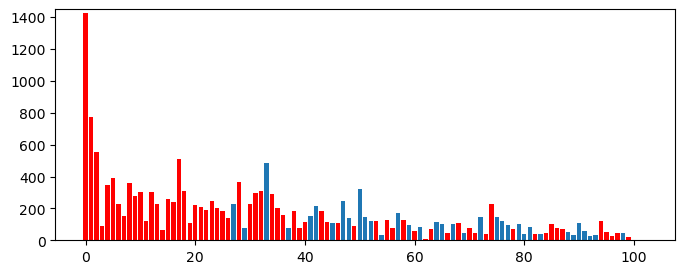

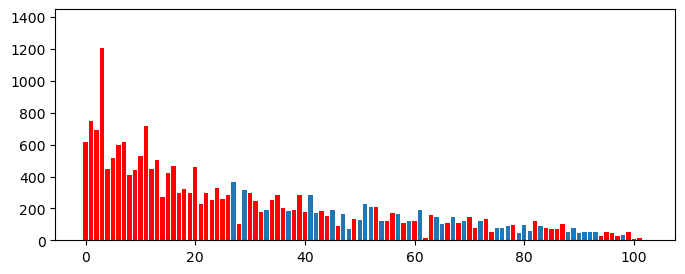

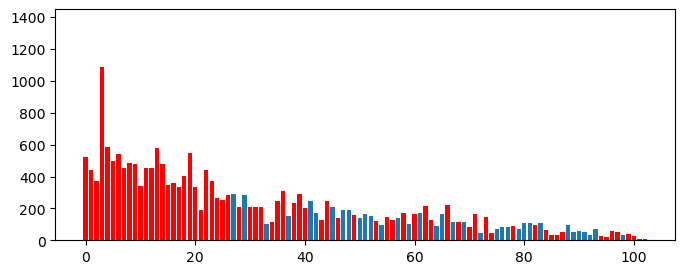

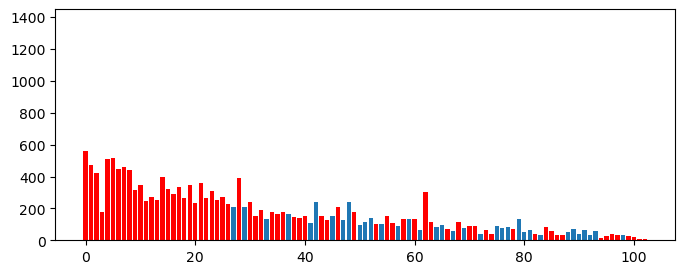

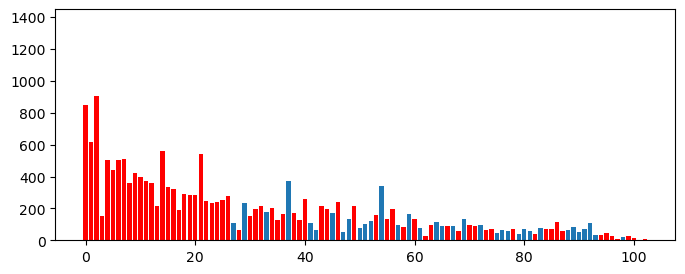

In [431]:
#cluster size - separate by pathology
with open(os.path.join(savedir_processed,'allCat'), 'rb') as output:
    allCat=pickle.load(output)
for p in range(pathorder.size):
    allcounts_p=np.zeros(np.unique(nextPartition).size)
    for cidx in range(np.unique(nextPartition).size):
        c=np.unique(nextPartition.astype(int))[cidx]
        allcounts_p[cidx]=np.sum(np.logical_and(nextPartition.astype(int)==c,allCat==pathorder[p]))
    figsize=(8, 3)
    fig,ax=plt.subplots(figsize=figsize)
    plt.bar(np.arange(allcounts_p.size),allcounts_p)
    plt.bar(np.arange(allcounts_p.size)[finalPartition_keep],allcounts_p[finalPartition_keep],color='red')
    plt.ylim(0,1450)
    plt.savefig(os.path.join(plotsavepath_curr,'clusterSizes_'+pathorder[p]+'.jpg'))
    plt.show()
    plt.close()

In [16]:
show_embedding_wBG(plotting_df[p_passedIdx[finalPartition==p][plottingIdx]], x_lab='umap1', y_lab='umap2', hue_lab='Cluster', ncol=5,savepath=os.path.join(plotsavepath_curr,'clusterUMAP_keep.pdf'))


In [15]:
minCells=20
nrandNeigh=20
spatialTestLevel=1
updateExisting=False
with open('/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/leiden_res5', 'rb') as output:
    nextPartition=pickle.load(output).astype('U300')
finalPartition=np.repeat('-1',currPartition.size).astype('U300')
    
clustersavepath={'-1':savedir_baseline}
clusterRes=5
subclusterRes=1

ls_cc_fin={}
# for currLevel in range(1,np.max(levelcounts)+1):
for currLevel in range(1,2):
    nextPartition=nextPartition.astype(int).astype('U300')
    
    print('level ',currLevel)
    nextPartition_passed=clusterLevels[currLevel]
    nextPartition_passedIdx=np.logical_and(nextPartition_passed!='-1',nextPartition_passed!='')
    
    for p in np.unique(finalPartition): 
        if np.unique(nextPartition_passed[finalPartition==p]).size==1:
            continue
        print('subcluster',p)
        p_passedIdx=np.logical_and(finalPartition==p,nextPartition_passedIdx)
        
        plotsavepath_curr=os.path.join(clustersavepath[p],'clusterPlots')
        if not os.path.exists(plotsavepath_curr):
            os.mkdir(plotsavepath_curr)
        c_prevIdx=finalPartition==p
        
        finalPartition_keep=np.unique(nextPartition[p_passedIdx].astype(int))
        

        #umap
        np.random.seed(3)
        plottingIdx=np.arange(np.sum(finalPartition==p))
        np.random.shuffle(plottingIdx)
        plotNumbers_curr=min(plotNumbers,plottingIdx.size)
        plottingIdx=plottingIdx[:plotNumbers_curr]

        if not os.path.exists(os.path.join(plotsavepath_curr,'umap_reducer')):
            pca=PCA(n_components=min(n_pcs_all,plotNumbers_curr-1))
            pca.fit(latent_all[plottingIdx])
            latent_all_pca=pca.transform(latent_all[plottingIdx])
            reducer_all = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=3).fit(latent_all_pca)
            with open(os.path.join(plotsavepath_curr,'umap_reducer'), 'wb') as output:
                pickle.dump(reducer_all, output, pickle.HIGHEST_PROTOCOL)
            with open(os.path.join(plotsavepath_curr,'pca'), 'wb') as output:
                pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)
        else:
            with open(os.path.join(plotsavepath_curr,'umap_reducer'), 'rb') as output:
                reducer_all=pickle.load(output)
            with open(os.path.join(plotsavepath_curr,'pca'), 'rb') as output:
                pca=pickle.load(output)

        finalPartition_keep_plot=np.copy(nextPartition[finalPartition==p])
        finalPartition_keep_plot[np.logical_not(nextPartition_passedIdx[finalPartition==p])]='-1'
        plotting_df = pd.DataFrame(
            {"Cluster":finalPartition_keep_plot[plottingIdx].astype(int)+1,
             "umap1":reducer_all.embedding_[:,0],
             "umap2":reducer_all.embedding_[:,1],
            }
        )
plotting_df

level  1
subcluster -1


,Cluster,umap1,umap2
0,0,3.018832,-0.181140
1,40,2.453965,-2.347628
2,0,2.381208,-0.514066
3,26,3.636833,0.458298
4,50,3.768345,-1.945426
...,...,...,...
9748,5,7.611117,-0.249836
9749,18,-0.200718,3.395710
9750,0,0.688965,0.305677
9751,1,-1.271561,4.720826


In [16]:
show_embedding_wBG(plotting_df[p_passedIdx[finalPartition==p][plottingIdx]], x_lab='umap1', y_lab='umap2', hue_lab='Cluster', ncol=5,savepath=os.path.join(plotsavepath_curr,'clusterUMAP_keep_shifted.pdf'))


level  1
subcluster -1
P1-18
P10-20-1
P10-20-2
P11-07
P13-12
P13-15
P15-16
P16-16-1
P16-16-2
P16-19-1
P16-19-2
P18-16
P19-16
P2-16
P2-20
P21-17
P21-17-2
P22-15
P24-10
P26-16
P28-15
P3-14
P30-12
P30-15
P31-16
P33-16
P33-18-1
P33-18-2
P37-15
P37-17
P37-18
P38-19-1
P38-19-2
P38-19-3
P45-15
P47-13
P47-19
P49-16
P49-18-1
P49-18-2
P49-18-3
P51-16
P54-14
P59-08
P59-08-2
P6-15
P63-05
P64-15
P66-18
P67-06
P68-15
P7-15
P70-15
P73-11
P73-11-2
P74-16
P75-13
P8-14
P82-15-1
P82-15-2
P85-19-1
P85-19-2
P89-19-1
P89-19-2
vabs  6.339850002884624
vabs  7.005624549193878
vabs  7.108524456778169


AssertionError: 

<Figure size 1000x800 with 0 Axes>

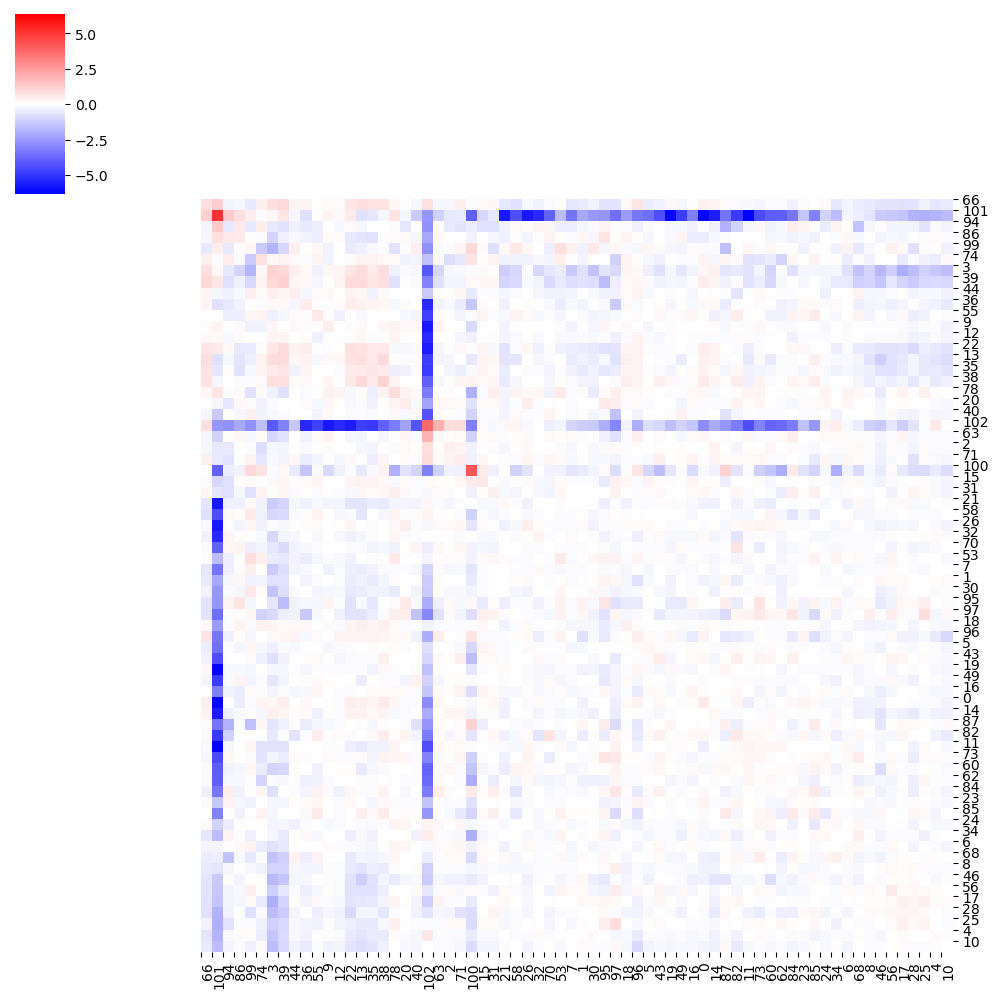

<Figure size 1000x800 with 0 Axes>

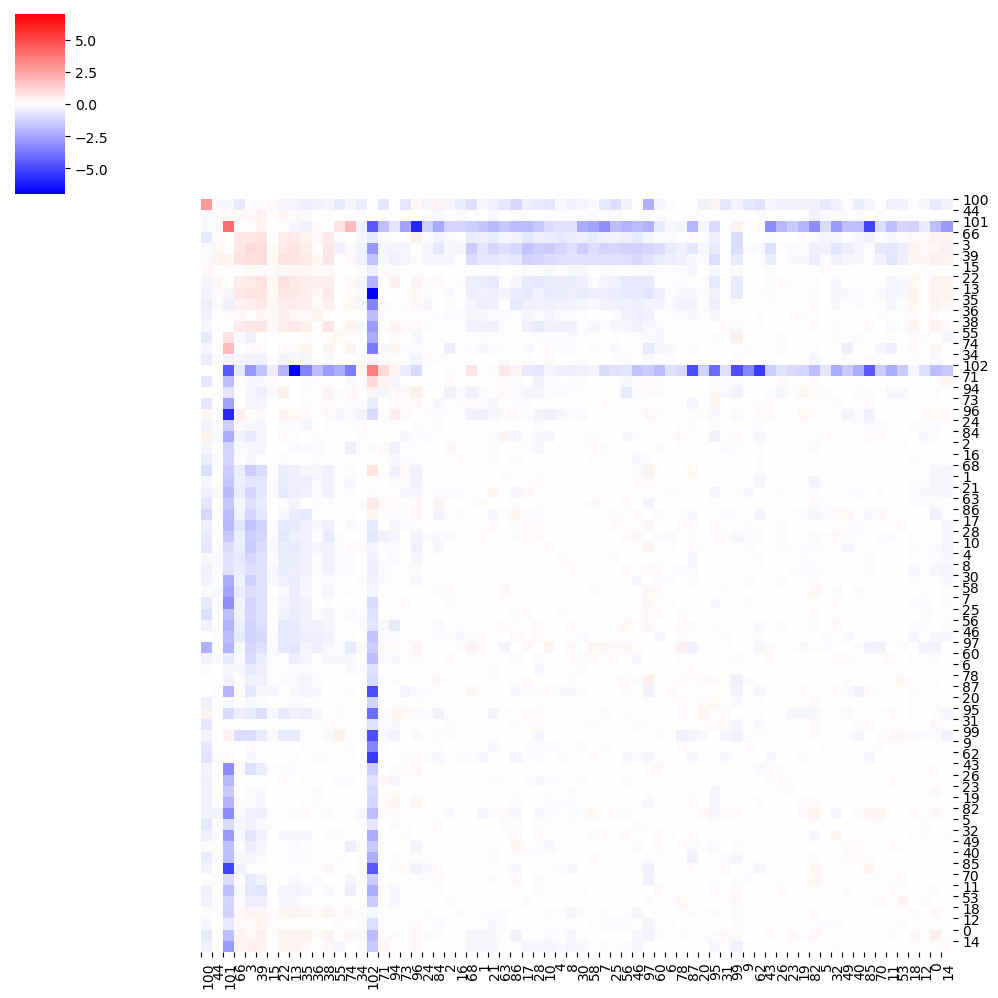

<Figure size 1000x800 with 0 Axes>

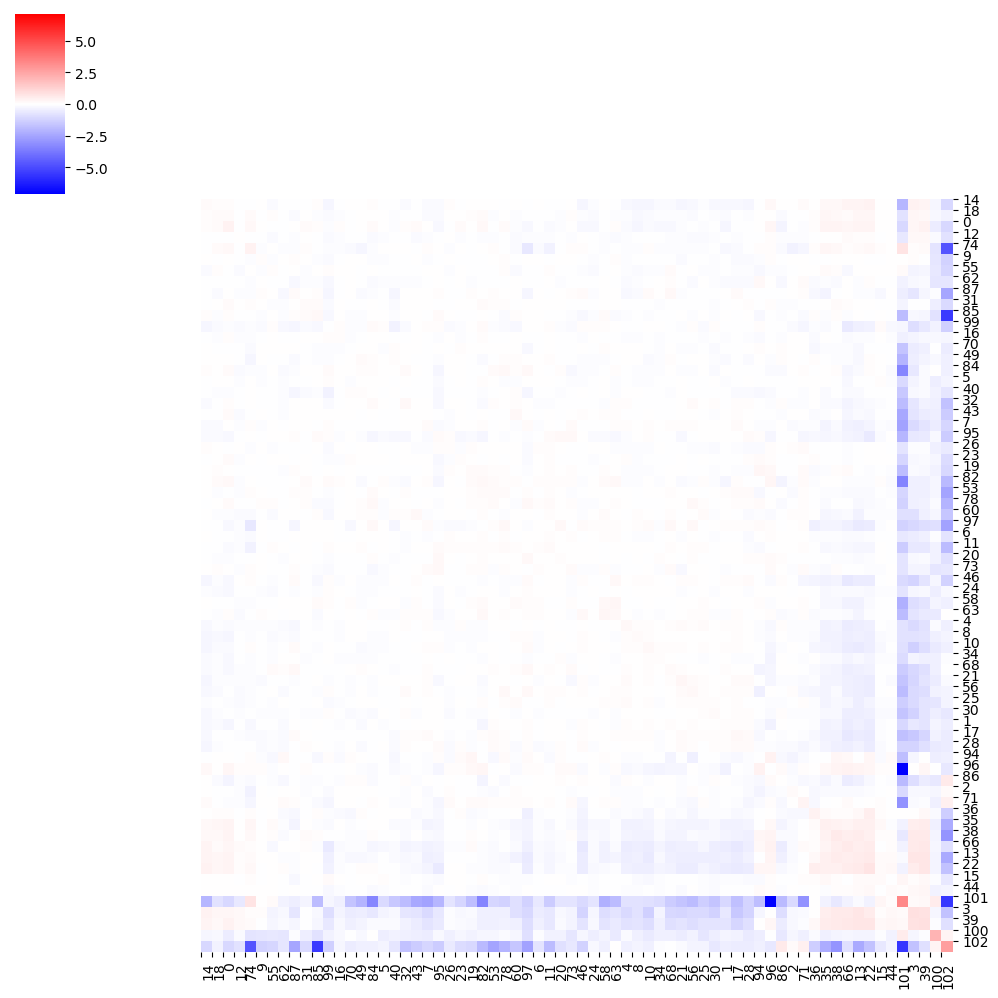

In [54]:
minCells=20
nrandNeigh=20
spatialTestLevel=1
updateExisting=False
with open('/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/leiden_res5', 'rb') as output:
    nextPartition=pickle.load(output).astype('U300')
finalPartition=np.repeat('-1',currPartition.size).astype('U300')
    
clustersavepath={'-1':savedir_baseline}
clusterRes=5
subclusterRes=1

ls_cc_fin={}
# for currLevel in range(1,np.max(levelcounts)+1):
for currLevel in range(1,2):
    nextPartition=nextPartition.astype(int).astype('U300')
    
    print('level ',currLevel)
    nextPartition_passed=clusterLevels[currLevel]
    nextPartition_passedIdx=np.logical_and(nextPartition_passed!='-1',nextPartition_passed!='')
    
    for p in np.unique(finalPartition): 
        if np.unique(nextPartition_passed[finalPartition==p]).size==1:
            continue
        print('subcluster',p)
        p_passedIdx=np.logical_and(finalPartition==p,nextPartition_passedIdx)
        
        plotsavepath_curr=os.path.join(clustersavepath[p],'clusterPlots')
        if not os.path.exists(plotsavepath_curr):
            os.mkdir(plotsavepath_curr)
        c_prevIdx=finalPartition==p
        
        finalPartition_keep=np.unique(nextPartition[p_passedIdx].astype(int))
        
#         #cluster size
#         if (not os.path.exists(os.path.join(plotsavepath_curr,'clusterSizes.jpg'))) or updateExisting:
#             _,allcounts=np.unique(nextPartition[c_prevIdx].astype(int),return_counts=True)
#             figsize=(max(3,15/103*allcounts.size), 3)
#             fig,ax=plt.subplots(figsize=figsize)
#             plt.bar(np.arange(allcounts.size),allcounts)
#             plt.bar(np.arange(allcounts.size)[finalPartition_keep],allcounts[finalPartition_keep],color='red')
#             plt.savefig(os.path.join(plotsavepath_curr,'clusterSizes.jpg'))
#             plt.close()


        #umap
        if (not os.path.exists(os.path.join(plotsavepath_curr,'clusterUMAP.pdf'))) or updateExisting:
            np.random.seed(3)
            plottingIdx=np.arange(np.sum(finalPartition==p))
            np.random.shuffle(plottingIdx)
            plotNumbers_curr=min(plotNumbers,plottingIdx.size)
            plottingIdx=plottingIdx[:plotNumbers_curr]

            if not os.path.exists(os.path.join(plotsavepath_curr,'umap_reducer')):
                pca=PCA(n_components=min(n_pcs_all,plotNumbers_curr-1))
                pca.fit(latent_all[plottingIdx])
                latent_all_pca=pca.transform(latent_all[plottingIdx])
                reducer_all = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=3).fit(latent_all_pca)
                with open(os.path.join(plotsavepath_curr,'umap_reducer'), 'wb') as output:
                    pickle.dump(reducer_all, output, pickle.HIGHEST_PROTOCOL)
                with open(os.path.join(plotsavepath_curr,'pca'), 'wb') as output:
                    pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)
            else:
                with open(os.path.join(plotsavepath_curr,'umap_reducer'), 'rb') as output:
                    reducer_all=pickle.load(output)
                with open(os.path.join(plotsavepath_curr,'pca'), 'rb') as output:
                    pca=pickle.load(output)

            finalPartition_keep_plot=np.copy(nextPartition[finalPartition==p])
            finalPartition_keep_plot[np.logical_not(nextPartition_passedIdx[finalPartition==p])]='not validated'
            plotting_df = pd.DataFrame(
                {"Cluster":finalPartition_keep_plot[plottingIdx],
                 "umap1":reducer_all.embedding_[:,0],
                 "umap2":reducer_all.embedding_[:,1],
                }
            )
            valstatus=np.copy(finalPartition_keep_plot[plottingIdx])
            valstatus[valstatus!='not validated']='validated'
            plotting_df_valstatus = pd.DataFrame(
                {"Cluster":valstatus,
                 "umap1":reducer_all.embedding_[:,0],
                 "umap2":reducer_all.embedding_[:,1],
                }
            )
            plotting_df_cat = pd.DataFrame(
                {"Cluster":allCat[finalPartition==p][plottingIdx],
                 "umap1":reducer_all.embedding_[:,0],
                 "umap2":reducer_all.embedding_[:,1],
                }
            )

    #         show_embedding_wBG(plotting_df, x_lab='umap1', y_lab='umap2', hue_lab='Cluster', savepath=os.path.join(plotsavepath_curr,'clusterUMAP.pdf'))
            show_embedding_wBG(plotting_df_valstatus, x_lab='umap1', y_lab='umap2', hue_lab='Cluster',ncol=1, savepath=os.path.join(plotsavepath_curr,'clusterUMAP_valstatus.pdf'))
            show_embedding_wBG(plotting_df[p_passedIdx[finalPartition==p][plottingIdx]], x_lab='umap1', y_lab='umap2', hue_lab='Cluster', savepath=os.path.join(plotsavepath_curr,'clusterUMAP_keep.pdf'))
            show_embedding_wBG(plotting_df_cat, x_lab='umap1', y_lab='umap2', hue_lab='Cluster',ncol=1, savepath=os.path.join(plotsavepath_curr,'catUMAP.pdf'))
            for cat_i in np.unique(allCat[finalPartition==p][plottingIdx]):
                allCat_i=np.copy(allCat[finalPartition==p][plottingIdx])
                allCat_i[allCat_i!=cat_i]='others'
                plotting_df_cat = pd.DataFrame(
                    {"Cluster":allCat_i,
                     "umap1":reducer_all.embedding_[:,0],
                     "umap2":reducer_all.embedding_[:,1],
                    }
                )
                show_embedding_wBG(plotting_df_cat, x_lab='umap1', y_lab='umap2', hue_lab='Cluster',ncol=1, savepath=os.path.join(plotsavepath_curr,'catUMAP_'+cat_i+'.pdf'))

        #examples divided by validated (red) and not validated (blue)
        if (not os.path.exists(os.path.join(plotsavepath_curr,'plotExample_'+stains[-1]+'.jpg'))) or updateExisting:
            for vidx in range(len(stains)):
                valStains_curr=stains[vidx]
                print(valStains_curr)
                valStains_currIdx=stains.tolist().index(valStains_curr)
                # add clf and gradient
                plotExample=np.zeros((nExamples*(imgSize+2),np.unique(nextPartition[c_prevIdx]).size*(imgSize+2),3))
                for cidx in range(np.unique(nextPartition[c_prevIdx]).size):
                    c=np.unique(nextPartition[c_prevIdx].astype(int))[cidx]
#                     print('plot example',c)
                    channelIdx=None
                    if int(c) in finalPartition_keep:
                        channelIdx=0
                    else:
                        channelIdx=2
                    imgIdx=np.arange(allImg.shape[0])[c_prevIdx][nextPartition[c_prevIdx].astype(int)==c]
                    np.random.seed(3)
                    np.random.shuffle(imgIdx)
                    plotIdx=imgIdx[:min(imgIdx.size,nExamples)]
                    print('sampled')
                    for plotIdx_idx in range(plotIdx.size):
                        plotExample[plotIdx_idx*(imgSize+2):plotIdx_idx*(imgSize+2)+imgSize,cidx*(imgSize+2):cidx*(imgSize+2)+imgSize,channelIdx]=allImg[plotIdx[plotIdx_idx],valStains_currIdx]
                plt.imsave(os.path.join(plotsavepath_curr,'plotExample_'+valStains_curr+'.jpg'),plotExample)
            
        #plot modFrac of each stain with thresh - also silhouette and robustness
        if (not os.path.exists(os.path.join(plotsavepath_curr,'robustness_fracOverlap_wRandom.jpg'))) or updateExisting:
            with open(os.path.join(clustersavepath[p],'modAll'), 'rb') as output:
                modAll=pickle.load(output)
            with open(os.path.join(clustersavepath[p],'silAll'), 'rb') as output:
                silAll=pickle.load(output)

            figsize=(max(3,15/103*modAll.size), 3)
            fig,ax=plt.subplots(figsize=figsize,layout='constrained')
            plt.bar(np.arange(modAll.size),modAll)
            plt.bar(np.arange(modAll.size)[finalPartition_keep],modAll[finalPartition_keep],color='red')
            plt.savefig(os.path.join(plotsavepath_curr,'modAll.jpg'))
            plt.close()

            modFrac_sum=np.zeros(np.unique(nextPartition[finalPartition==p]).size)
            silmean_frac_sum=np.zeros(np.unique(nextPartition[finalPartition==p]).size)
            silPos_sum=np.zeros(np.unique(nextPartition[finalPartition==p]).size)

            silAll_mean=np.zeros(np.unique(nextPartition[finalPartition==p]).size)
            for c in np.unique(nextPartition[finalPartition==p]):
                silAll_mean[int(c)]=np.mean(silAll[nextPartition[finalPartition==p]==c])
            silAll_pos=np.zeros(np.unique(nextPartition[finalPartition==p]).size)
            for c in np.unique(nextPartition[finalPartition==p]):
                silAll_pos[int(c)]=np.sum(silAll[nextPartition[finalPartition==p]==c]>0)/np.sum(nextPartition[finalPartition==p]==c)


            fig,ax=plt.subplots(figsize=figsize,layout='constrained')
            plt.bar(np.arange(silAll_mean.size),silAll_mean)
            plt.bar(np.arange(silAll_mean.size)[finalPartition_keep],silAll_mean[finalPartition_keep],color='red')
            plt.savefig(os.path.join(plotsavepath_curr,'silAll_mean.jpg'))
            plt.close()

            fig,ax=plt.subplots(figsize=figsize,layout='constrained')
            plt.bar(np.arange(silAll_pos.size),silAll_pos)
            plt.bar(np.arange(silAll_pos.size)[finalPartition_keep],silAll_pos[finalPartition_keep],color='red')
            plt.savefig(os.path.join(plotsavepath_curr,'silAll_pos.jpg'))
            plt.close()

            valtype=np.repeat('',modAll.size).astype('U100')
            for s in stains:
                print(s)
                modstainPath=os.path.join(clustersavepath[p],'mod'+s.lower())
                with open(modstainPath, 'rb') as output:
                    modstain=pickle.load(output)
                with open(os.path.join(clustersavepath[p],'sil'+s.lower()), 'rb') as output:
                    silstain=pickle.load(output)

                modstain_ratio=modstain/modAll
                modFrac_stain=(modstain_ratio>modFrac).astype(int)

                fig,ax=plt.subplots(figsize=figsize,layout='constrained')
                plt.bar(np.arange(modAll.size),modstain_ratio)
                plt.bar(np.arange(modAll.size)[finalPartition_keep],modstain_ratio[finalPartition_keep],color='red')
                plt.axhline(y =modFrac, color = 'green', linestyle = '-')
                plt.savefig(os.path.join(plotsavepath_curr,'mod'+s+'_modAll_ratio.jpg'))
                plt.close()

                silstain_mean=np.zeros(np.unique(nextPartition[finalPartition==p]).size)
                for c in np.unique(nextPartition[finalPartition==p]):
                    silstain_mean[int(c)]=np.mean(silstain[nextPartition[finalPartition==p]==c])
                silmean_frac_stain=val.comparesilmean(silstain_mean,silAll_mean,silmean_frac,silmean_frac_neg)

                silstain_mean_posIdx=np.arange(silAll_mean.size)[silstain_mean>0]
                silstain_mean_negIdx=np.arange(silAll_mean.size)[silstain_mean<0]
                fig,ax=plt.subplots(figsize=figsize,layout='constrained')
                plt.bar(np.arange(modAll.size),silstain_mean)
                plt.bar(np.arange(modAll.size)[finalPartition_keep],silstain_mean[finalPartition_keep],color='red')
                plt.scatter(np.arange(modAll.size)[silstain_mean_posIdx],silAll_mean[silstain_mean_posIdx]*silmean_frac,color='green',s=2)
                plt.scatter(np.arange(modAll.size)[silstain_mean_negIdx],silAll_mean[silstain_mean_negIdx]*silmean_frac_neg,color='green',s=2)
                plt.savefig(os.path.join(plotsavepath_curr,'sil'+s+'_mean.jpg'))
                plt.close()

                silpos_stain=np.zeros(np.unique(nextPartition[finalPartition==p]).size)
                for c in np.unique(nextPartition[finalPartition==p]):
                    silpos_stain[int(c)]=np.sum(silstain[nextPartition[finalPartition==p]==c]>0)/np.sum(nextPartition[finalPartition==p]==c)

                silstain_ratio=silpos_stain/silAll_pos

                fig,ax=plt.subplots(figsize=figsize,layout='constrained')
                plt.bar(np.arange(modAll.size),silstain_ratio)
                plt.bar(np.arange(modAll.size)[finalPartition_keep],silstain_ratio[finalPartition_keep],color='red')
                plt.axhline(y =silpos_frac, color = 'green', linestyle = '-')
                plt.savefig(os.path.join(plotsavepath_curr,'sil'+s+'_silAll_pos_ratio.jpg'))
                plt.close()

                silpos_stain=(silstain_ratio>silpos_frac).astype(int)

                passIdx_stain=(modFrac_stain+silmean_frac_stain+silpos_stain)>0
                valtype[passIdx_stain]=np.char.add(valtype[passIdx_stain],np.repeat(s+' ',np.sum(passIdx_stain)))

            finalPartition_keep_bool=np.repeat(False,np.unique(nextPartition[c_prevIdx]).size)
            finalPartition_keep_bool[finalPartition_keep]=True
            summary=pd.DataFrame(data={'val_stain':valtype,'pass':finalPartition_keep_bool})
            summary.to_csv(os.path.join(plotsavepath_curr,'valtype.csv'))

            with open(os.path.join(clustersavepath[p],'leidenRes'+str(clusterRes)+'_10samples'), 'rb') as output:
                leidenResAll=pickle.load(output)

            leidenJoint_overlap=np.zeros((np.unique(nextPartition[finalPartition==p]).size,nsamples))
            for cj in np.unique(nextPartition[finalPartition==p]):
                for si in range(nsamples):
                    _,counts=np.unique(leidenResAll[nextPartition[finalPartition==p]==cj,si],return_counts=True)
                    leidenJoint_overlap[int(cj),si]=np.max(counts)/np.sum(nextPartition[finalPartition==p]==cj)

            overlap_mean=np.mean(leidenJoint_overlap,axis=1)
            overlap_std=np.std(leidenJoint_overlap,axis=1)

            overlap_mean=np.mean(leidenJoint_overlap,axis=1)
            overlap_std=np.std(leidenJoint_overlap,axis=1)

            randomAll=np.zeros((leidenResAll.shape[0],nsamples)).astype(int)

            for s in range(nsamples):
                randomS=np.copy(nextPartition[finalPartition==p])
                np.random.seed(s)
                np.random.shuffle(randomS)

                randomAll[:,s]=randomS
            leidenJoint_overlap_random=np.zeros((np.unique(nextPartition[finalPartition==p]).size,nsamples))
            for cj in np.unique(nextPartition[finalPartition==p]):
                for s in range(nsamples):
                    _,counts=np.unique(randomAll[nextPartition[finalPartition==p]==cj,s],return_counts=True)
                    leidenJoint_overlap_random[int(cj),s]=np.max(counts)/np.sum(nextPartition[finalPartition==p]==cj)

            overlap_mean_random=np.mean(leidenJoint_overlap_random,axis=1)
            overlap_std_random=np.std(leidenJoint_overlap_random,axis=1)

            fig,ax=plt.subplots(figsize=figsize,layout='constrained')
            plt.bar(np.arange(overlap_mean.size),overlap_mean)
            plt.bar(np.arange(overlap_mean.size)[finalPartition_keep],overlap_mean[finalPartition_keep],color='red')
            plt.errorbar(np.arange(overlap_mean.size),overlap_mean,yerr=overlap_std,fmt='o',ms=1,color='r')
            
            plt.scatter(np.arange(overlap_mean.size),overlap_mean_random)
            plt.savefig(os.path.join(plotsavepath_curr,'robustness_fracOverlap_wRandom.jpg'))
            plt.close()
        
        #spatial vs cluster
        allImgNames_p=allImgNames[p_passedIdx]
        distByImg_p={}
        for img_i in np.unique(allImgNames_p):
            print(img_i)
            distByImg_p[img_i]=distByImg[img_i][p_passedIdx[allImgNames==img_i]]

        clusterIdx_curr=clusterLevels_names[spatialTestLevel]!='-1'
        for sr in range(len(spatialRegions)):
#             if currLevel==1:
#                 continue
            if finalPartition_keep.size<2:
                continue
            if os.path.exists(os.path.join(plotsavepath_curr,'neighborhood_allCells_'+str(spatialRegions[sr]))):
                with open(os.path.join(plotsavepath_curr,'neighborhood_allCells_'+str(spatialRegions[sr])), 'rb') as output:
                    res=pickle.load(output)
            else:
                print('spatial ',spatialRegions[sr])
                res=np.zeros((allImgNames_p.size,np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr]).size+1))
                for img_i in np.unique(allImgNames_p):
                    print(img_i)
                    nsamples=np.sum(p_passedIdx[allImgNames==img_i])
                    clusterIdx_curr_i=np.logical_and(allImgNames_p==img_i,clusterIdx_curr[p_passedIdx])
                    cluster_i=clusterLevels_names[spatialTestLevel][allImgNames==img_i][clusterIdx_curr[allImgNames==img_i]]

                    distIn=np.logical_and(distByImg_p[img_i]<spatialRegions[sr],distByImg_p[img_i]>0)
                    distIn=distIn[:,clusterIdx_curr[allImgNames==img_i]]
                    cell_i_all=np.arange(allImgNames_p.size)[allImgNames_p==img_i]
                    for cell_i in range(nsamples):
                        neighborID,neighborCount=np.unique(cluster_i[distIn[cell_i]],return_counts=True)
    #                     print(neighborID)
                        _,neighborcountIdx,neighborIDidx=np.intersect1d(neighborID.astype(int),np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr].astype(int)),return_indices=True)
                        res[cell_i_all[cell_i],neighborIDidx]=neighborCount[neighborcountIdx]
                res[:,-1]=np.sum(res,axis=1)
                nonzeroIdx=res[:,-1]>0
                res[nonzeroIdx,:-1]=res[nonzeroIdx,:-1]/res[nonzeroIdx][:,[-1]]

                with open(os.path.join(plotsavepath_curr,'neighborhood_allCells_'+str(spatialRegions[sr])), 'wb') as output:
                    pickle.dump(res, output, pickle.HIGHEST_PROTOCOL)
            
            
            #compute random distributions
            if os.path.exists(os.path.join(plotsavepath_curr,'neighborhoodRandom_allCells_'+str(spatialRegions[sr]))):
                with open(os.path.join(plotsavepath_curr,'neighborhoodRandom_allCells_'+str(spatialRegions[sr])), 'rb') as output:
                    resRand=pickle.load(output)
                with open(os.path.join(plotsavepath_curr,'neighborhoodRandomCluster_allCells_'+str(spatialRegions[sr])), 'rb') as output:
                    resRand_clusterOrder=pickle.load(output)
            else:
                print('spatial ',spatialRegions[sr])
                resRand=np.zeros((nrandNeigh,allImgNames_p.size,np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr]).size+1))
                resRand_clusterOrder=np.zeros((nrandNeigh,allImgNames_p.size))
                for seed in range(nrandNeigh):
                    for img_i in np.unique(allImgNames_p):
                        print(img_i)
                        nsamples=np.sum(p_passedIdx[allImgNames==img_i])
                        clusterIdx_curr_i=np.logical_and(allImgNames_p==img_i,clusterIdx_curr[p_passedIdx])
                        cluster_i=clusterLevels_names[spatialTestLevel][allImgNames==img_i][clusterIdx_curr[allImgNames==img_i]]
                        #shuffle
                        np.random.seed(seed)
                        np.random.shuffle(cluster_i)
                        
                        distIn=np.logical_and(distByImg_p[img_i]<spatialRegions[sr],distByImg_p[img_i]>0)
                        distIn=distIn[:,clusterIdx_curr[allImgNames==img_i]]
                        cell_i_all=np.arange(allImgNames_p.size)[allImgNames_p==img_i]
                        resRand_clusterOrder[seed,cell_i_all]=cluster_i[p_passedIdx[allImgNames==img_i][clusterIdx_curr[allImgNames==img_i]]]
                        for cell_i in range(nsamples):
                            neighborID,neighborCount=np.unique(cluster_i[distIn[cell_i]],return_counts=True)
        #                     print(neighborID)
                            _,neighborcountIdx,neighborIDidx=np.intersect1d(neighborID.astype(int),np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr].astype(int)),return_indices=True)
                            resRand[seed,cell_i_all[cell_i],neighborIDidx]=neighborCount[neighborcountIdx]
#                     res[:,-1]=np.sum(res,axis=1)
#                     nonzeroIdx=res[:,-1]>0
#                     res[nonzeroIdx,:-1]=res[nonzeroIdx,:-1]/res[nonzeroIdx][:,[-1]]

                with open(os.path.join(plotsavepath_curr,'neighborhoodRandom_allCells_'+str(spatialRegions[sr])), 'wb') as output:
                    pickle.dump(resRand, output, pickle.HIGHEST_PROTOCOL)
                with open(os.path.join(plotsavepath_curr,'neighborhoodRandomCluster_allCells_'+str(spatialRegions[sr])), 'wb') as output:
                    pickle.dump(resRand_clusterOrder, output, pickle.HIGHEST_PROTOCOL)

            
            #compare to random assignments
            res_noNorm=np.copy(res[:,:-1]*res[:,[-1]])
            
            resPlot_bg=np.zeros((finalPartition_keep.size,res_noNorm.shape[1]))
            for cidx in range(finalPartition_keep.size):
                c=finalPartition_keep[cidx]
                if np.sum(nextPartition[p_passedIdx]==str(c))==0:
                    continue
                res_in=np.sum(res_noNorm[nextPartition[p_passedIdx]==str(c)],axis=0)
                res_out=np.sum(resRand[resRand_clusterOrder==c,:-1],axis=0) 
                resPlot_bg[cidx]=np.log2((res_in+0.1)/(res_out/resRand.shape[0]+0.1))
#                 resPlot_bg[cidx]=res_in-res_out
#             if not os.path.exists(os.path.join(plotsavepath_curr,'neighborhood_clusterBGexpected_'+str(spatialRegions[sr])+'.pdf')):
            vabs=np.max(np.absolute(resPlot_bg[np.isfinite(resPlot_bg)]))
            figsize=(15,max(3,15/103*finalPartition_keep.size))
            fig, ax = plt.subplots(figsize=figsize)
            im = ax.imshow(resPlot_bg,cmap='bwr',vmin=-vabs,vmax=vabs)
            ax.set_yticks(np.arange(resPlot_bg.shape[0]))
            ax.set_yticklabels(finalPartition_keep.astype(int))
            ax.set_xticks(np.arange(resPlot_bg.shape[1]))
            ax.set_xticklabels(np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr].astype(int)).astype(str))
            plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
            fig.colorbar(im)
            fig.tight_layout()
            plt.savefig(os.path.join(plotsavepath_curr,'neighborhood_clusterBGRand_'+str(spatialRegions[sr])+'.pdf'))
            plt.close()                
            
            if not os.path.exists(os.path.join(plotsavepath_curr,'neighborhood_allCells_counts_'+str(spatialRegions[sr]))):
                resCounts=np.zeros(allImgNames_p.size)
                for img_i in np.unique(allImgNames_p):
                    print(img_i)
                    nsamples=np.sum(p_passedIdx[allImgNames==img_i])
                    clusterIdx_curr_i=np.logical_and(allImgNames_p==img_i,clusterIdx_curr[p_passedIdx])
                    cluster_i=clusterLevels_names[spatialTestLevel][allImgNames==img_i][clusterIdx_curr[allImgNames==img_i]]

                    distIn=np.logical_and(distByImg_p[img_i]<spatialRegions[sr],distByImg_p[img_i]>0)
    #                 distIn=distIn[:,clusterIdx_curr[allImgNames==img_i]]
                    cell_i_all=np.arange(allImgNames_p.size)[allImgNames_p==img_i]
                    resCounts[cell_i_all]=np.sum(distIn,axis=1)

                with open(os.path.join(plotsavepath_curr,'neighborhood_allCells_counts_'+str(spatialRegions[sr])), 'wb') as output:
                    pickle.dump(resCounts, output, pickle.HIGHEST_PROTOCOL)
            with open(os.path.join(plotsavepath_curr,'neighborhood_allCells_counts_'+str(spatialRegions[sr])), 'rb') as output:
                resCounts=pickle.load(output)
                
            resCountsPlot=np.zeros(finalPartition_keep.size)
            for cidx in range(finalPartition_keep.size):
                c=finalPartition_keep[cidx]
                res_in=np.mean(resCounts[nextPartition[p_passedIdx]==str(c)])
                res_out=np.mean(resCounts[nextPartition[p_passedIdx]!=str(c)])
                resCountsPlot[cidx]=np.log2(res_in/res_out)

            vabs=np.max(np.absolute(resCountsPlot))
            figsize=(3,max(3,15/103*finalPartition_keep.size))
            fig, ax = plt.subplots(figsize=figsize)
            im = ax.imshow(resCountsPlot.reshape(-1,1),cmap='bwr',vmin=-vabs,vmax=vabs)
            ax.set_yticks(np.arange(resCountsPlot.shape[0]))
            ax.set_yticklabels(finalPartition_keep.astype(int))
            ax.set_xticks([1])
            ax.set_xticklabels(['counts'])
            plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
            fig.colorbar(im)
            fig.tight_layout()
            plt.savefig(os.path.join(plotsavepath_curr,'neighborhood_cluster_cellcounts_'+str(spatialRegions[sr])+'.pdf'))
            plt.close()
            
            vabs=np.max(np.absolute(resCountsPlot))
            figsize=(3,max(3,15/103*finalPartition_keep.size))
            fig, ax = plt.subplots(figsize=figsize)
            im = ax.imshow(resCountsPlot[ls_cc].reshape(-1,1),cmap='bwr',vmin=-vabs,vmax=vabs)
            ax.set_yticks(np.arange(resCountsPlot.shape[0]))
            ax.set_yticklabels(finalPartition_keep.astype(int)[ls_cc])
            ax.set_xticks([1])
            ax.set_xticklabels(['counts'])
            plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
            fig.colorbar(im)
            fig.tight_layout()
            plt.savefig(os.path.join(plotsavepath_curr,'neighborhood_clusterByCorrBGRand_cellcounts_'+str(spatialRegions[sr])+'.pdf'))
            plt.close()
            
            #dendrogram - cluster row correlations
            resPlotDF = pd.DataFrame(np.transpose(resPlot_bg), columns=np.arange(finalPartition_keep.size))
            corr = resPlotDF.corr()
            cluster_grid = sns.clustermap(corr, method='average', cmap='bwr', vmin=-1, vmax=1, row_cluster=True, col_cluster=True)
            row_order = cluster_grid.dendrogram_row.reordered_ind
            if currLevel==1:
                ls_cc_fin[spatialRegions[sr]]=np.copy(row_order)
            reordered_resPlot_bg = resPlot_bg[row_order, :][:, row_order]
            vabs = np.max(np.absolute(reordered_resPlot_bg[np.isfinite(reordered_resPlot_bg)]))
            print('vabs ',vabs)
            im = cluster_grid.ax_heatmap.imshow(reordered_resPlot_bg, cmap='bwr', vmin=-vabs, vmax=vabs)

            cluster_grid.cax.clear()  # Clear the existing colorbar
            plt.colorbar(im, cax=cluster_grid.cax)  # Add the new colorbar

            yticklabels = finalPartition_keep.astype(int)[row_order]
            cluster_grid.ax_heatmap.set_yticks(np.arange(len(yticklabels)))
            cluster_grid.ax_heatmap.set_yticklabels(yticklabels)
            xticklabels = np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr].astype(int)).astype(str)[ls_cc_fin[spatialRegions[sr]]]
            cluster_grid.ax_heatmap.set_xticks(np.arange(len(xticklabels)))
            cluster_grid.ax_heatmap.set_xticklabels(xticklabels)

            # Rotate x-tick labels for better visibility
            plt.setp(cluster_grid.ax_heatmap.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

            plt.savefig(os.path.join(plotsavepath_curr,'neighborhood_clusterByCorrBGRand_dendroCorr_'+str(spatialRegions[sr])+'.pdf'))
            plt.close()
            
            plt.figure(figsize=(10, 8))
            new_clustermap = sns.clustermap(reordered_resPlot_bg, cmap='bwr', vmin=-vabs, vmax=vabs, row_cluster=False, col_cluster=False)

            yticklabels = finalPartition_keep.astype(int)[row_order]
            xticklabels = np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr].astype(int)).astype(str)[ls_cc_fin[spatialRegions[sr]]]

            new_clustermap.ax_heatmap.set_yticks(np.arange(len(yticklabels)))
            new_clustermap.ax_heatmap.set_yticklabels(yticklabels)
            new_clustermap.ax_heatmap.set_xticks(np.arange(len(xticklabels)))
            new_clustermap.ax_heatmap.set_xticklabels(xticklabels)


            plt.setp(new_clustermap.ax_heatmap.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
            new_clustermap.savefig(os.path.join(plotsavepath_curr,'neighborhood_clusterByCorrBGRand_dendro_'+str(spatialRegions[sr])+'.pdf'))
            plt.close

        
#         assert False
        
        

    clusterRes=subclusterRes  

    clustersavepath_new={}
    #subcluster
    nextPartition=np.zeros(nextPartition.size)-1
    for p in np.unique(clusterLevels_names[currLevel]):
        if np.sum(clusterLevels_names[currLevel]==p)<minCells or finalPartition[clusterLevels_names[currLevel]==p][0]==p:
            continue
        print('subcluster',p)
        
        clustersavepath_new[p]=os.path.join(clustersavepath[finalPartition[clusterLevels_names[currLevel]==p][0]],'subcluster_'+clusterLevels_names[currLevel][clusterLevels_names[currLevel]==p][0])
        
        with open(os.path.join(clustersavepath_new[p],'leiden'+str(subclusterRes)), 'rb') as output:
            nextPartition[clusterLevels_names[currLevel]==p]=pickle.load(output)
            
    finalPartition=np.copy(clusterLevels_names[currLevel])
    clustersavepath=clustersavepath_new
    

In [56]:
with open('/data/xzhang/neuro/results/jointClustering/baseline/res5/clusterPlots/ls_cc_level1Val_dendro', 'wb') as output:
    pickle.dump(ls_cc_fin, output, pickle.HIGHEST_PROTOCOL)

In [55]:
ls_cc_fin

{300: array([48, 66, 60, 58, 64, 53,  3, 35, 38, 33, 42,  9, 12, 22, 13, 32, 34,
        54, 20, 36, 67, 47,  2, 51, 65, 15, 29, 21, 44, 26, 30, 50, 41,  7,
         1, 28, 61, 63, 18, 62,  5, 37, 19, 40, 16,  0, 14, 59, 55, 11, 52,
        45, 46, 56, 23, 57, 24, 31,  6, 49,  8, 39, 43, 17, 27, 25,  4, 10]),
 650: array([65, 38, 66, 48,  3, 35, 15, 22, 13, 32, 33, 34, 42, 53, 31, 67, 51,
        60, 52, 62, 24, 56,  2, 16, 49,  1, 21, 47, 58, 17, 27, 10,  4,  8,
        28, 44,  7, 25, 43, 39, 63, 45,  6, 54, 59, 20, 61, 29, 64,  9, 46,
        37, 26, 23, 19, 55,  5, 30, 40, 36, 57, 50, 11, 41, 18, 12,  0, 14]),
 1000: array([14, 18,  0, 12, 53,  9, 42, 46, 59, 29, 57, 64, 16, 50, 40, 56,  5,
        36, 30, 37,  7, 61, 26, 23, 19, 55, 41, 54, 45, 63,  6, 11, 20, 52,
        39, 24, 44, 47,  4,  8, 10, 31, 49, 21, 43, 25, 28,  1, 17, 27, 60,
        62, 58,  2, 51, 33, 32, 34, 48, 13, 22, 15, 38, 66,  3, 35, 65, 67])}

In [34]:
savedir_processed_new='/data/xzhang/neuro_new/newdata/tauAbeta_tiff/processed'
with open(os.path.join(savedir_processed_new,'allPatientID'), 'rb') as output:
    allPatientIDs_new=pickle.load(output)

In [ ]:
meta_table1=meta.copy()
meta_table1=meta_table1.loc[np.intersect1d(meta_table1.index,np.unique(np.concatenate((allPatientID,allPatientIDs_new))))]

In [40]:
meta_table1.to_csv('supptable1.csv')

In [26]:
colors={'DAPI GFAP MAP2 LMNB ':[255,0,0],
        'DAPI GFAP LMNB ':[153,51,255],
        'DAPI MAP2 LMNB ':[255,102,255],
        'DAPI GFAP ':[204,153,255],
        'DAPI LMNB ':[204,204,0],
        'GFAP LMNB ':[153,153,255],
        'GFAP MAP2 ':[0,0,255], 
        'GFAP MAP2 LMNB ':[0,128,255],
        'MAP2 LMNB ':[255,153,204]}
for key in colors:
    colors[key] = np.array(colors[key]) / 255.0

In [23]:
valtypes_level1_df=pd.read_csv(os.path.join(savedir_baseline,'clusterPlots','valtype.csv'))
valtypes_level1_df

,Unnamed: 0,val_stain,pass
0,0,DAPI GFAP LMNB,True
1,1,GFAP MAP2,True
2,2,DAPI GFAP MAP2 LMNB,True
3,3,DAPI GFAP MAP2 LMNB,True
4,4,DAPI LMNB,True
...,...,...,...
98,98,NaN,False
99,99,DAPI LMNB,True
100,100,GFAP MAP2,True
101,101,DAPI GFAP MAP2 LMNB,True


In [24]:
valtypePlotCluster=np.concatenate(([-1],np.unique(valtypes_level1_df.index[valtypes_level1_df['pass'].astype(bool)])))

In [27]:
valtypePlot=np.zeros((1,valtypePlotCluster.size,3))
for cidx in range(1,valtypePlotCluster.size):
    valtypePlot[0,cidx]=colors[valtypes_level1_df['val_stain'].loc[valtypePlotCluster[cidx]]]

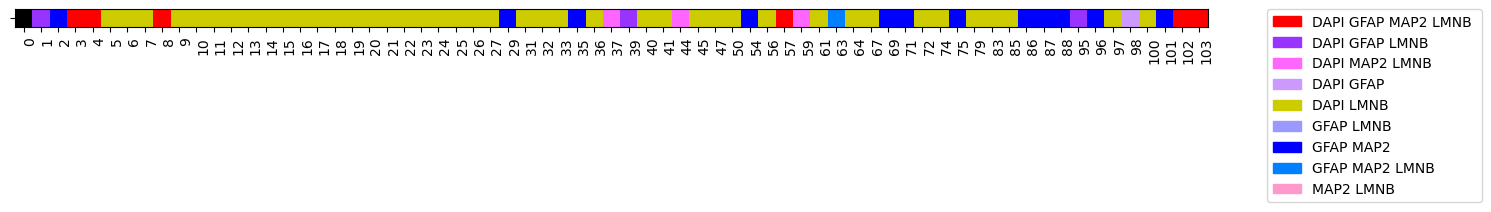

In [30]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(valtypePlot)
legend_patches = [mpatches.Patch(color=np.array(colors[label]), label=label) for label in colors]

# Add the legend to the plot
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xticks(np.arange(valtypePlot.shape[1]))
ax.set_xticklabels(valtypePlotCluster+1)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
ax.set_yticks(np.arange(1))
ax.set_yticklabels('')
fig.tight_layout()

plt.savefig(os.path.join(savedir_baseline,'clusterPlots','valtype.pdf'))

In [357]:
valPassUnique,valPassCounts=np.unique(valtypes_level1_df['val_stain'][valtypes_level1_df['pass'].astype(bool)],return_counts=True)

In [358]:
dapilmnbInclude=valPassCounts[valPassUnique=='DAPI GFAP MAP2 LMNB ']+valPassCounts[valPassUnique=='DAPI MAP2 LMNB ']+valPassCounts[valPassUnique=='DAPI GFAP LMNB ']+valPassCounts[valPassUnique=='DAPI LMNB ']
dapilmnbOnly=valPassCounts[valPassUnique=='DAPI LMNB ']
print(dapilmnbOnly)
print(dapilmnbOnly/np.sum(valPassCounts))
print(dapilmnbInclude)
print(dapilmnbInclude/np.sum(valPassCounts))

[42]
[0.61764706]
[54]
[0.79411765]


In [360]:
ls_cc_fin_clusters={}
for sr in ls_cc_fin.keys():
    ls_cc_fin_clusters[sr]=valtypePlotCluster[1:][ls_cc_fin[sr]]

In [362]:
with open('/data/xzhang/neuro/results/jointClustering/baseline/res5/clusterPlots/ls_cc_level1Val', 'wb') as output:
    pickle.dump(ls_cc_fin_clusters, output, pickle.HIGHEST_PROTOCOL)

In [365]:
#MAP2 and GFAP levels
with open('/data/xzhang/neuro/results/jointClustering/baseline/res5/clusterPlots/ls_cc_level1Val', 'rb') as output:
    ls_cc_fin=pickle.load(output)
    
#GFAP
sUnique,sidx=np.unique(allImgNames,return_index=True)
gfapSum=np.zeros(allImgNames.size)
for i in range(sUnique.size):
    testgfap=np.copy(allImg[allImgNames==sUnique[i],1])
    gfapBG=np.percentile(testgfap,75)
    testgfap=testgfap-gfapBG
    testgfap[testgfap<0]=0
    testgfap=testgfap/np.max(testgfap,axis=(1,2),keepdims=True)
    gfapSum[allImgNames==sUnique[i]]=np.sum(testgfap,axis=(1,2))

#map2
sUnique,sidx=np.unique(allImgNames,return_index=True)
map2Sum=np.zeros(allImgNames.size)
for i in range(sUnique.size):
    testmap2=np.copy(allImg[allImgNames==sUnique[i],2])
    map2BG=np.percentile(testmap2,75)
    testmap2=testmap2-map2BG
    testmap2[testmap2<0]=0
    testmap2=testmap2/np.max(testmap2,axis=(1,2),keepdims=True)
    map2Sum[allImgNames==sUnique[i]]=np.sum(testmap2,axis=(1,2))

markersum=np.zeros((2,ls_cc_fin[sr].size))
for c in range(ls_cc_fin[sr].size):
    markersum[0,c]=np.median(gfapSum[clusterLevels_names[1].astype(int)==ls_cc_fin[sr][c]])
    markersum[1,c]=np.median(map2Sum[clusterLevels_names[1].astype(int)==ls_cc_fin[sr][c]])

In [5]:
pathdiagNames,pathdiagCounts=np.unique(meta.loc[np.unique(allPatientID)]['Path Diag'],return_counts=True)
pathdiagNames

array(['AD', 'Control', 'FTLD-TDPC', 'IPD', 'PSP'], dtype=object)

In [6]:
pathdiagCounts

array([10, 10, 10, 10, 10])

In [9]:
sUnique,sidx_start=np.unique(allImgNames,return_index=True)
pathdiagNames_sample,pathdiagCounts_sample=np.unique(meta.loc[allPatientID[sidx_start]]['Path Diag'],return_counts=True)
pathdiagNames_sample

array(['AD', 'Control', 'FTLD-TDPC', 'IPD', 'PSP'], dtype=object)

In [13]:
pathdiagNames_cells,pathdiagCounts_cells=np.unique(meta.loc[allPatientID]['Path Diag'],return_counts=True)
pathdiagCounts_cells

array([22387, 17139, 21626, 18889, 17489])

In [10]:
pathdiagCounts_sample

array([10, 22, 10, 12, 10])

In [11]:
pathPlot=np.vstack((pathdiagCounts,pathdiagCounts_sample))
pathOrder=np.array(['Control','AD','FTLD-TDPC','PSP','IPD'])
_,pathOrderIdx=np.unique(pathOrder,return_inverse=True)

In [44]:
pathPlot_val=[[2,4,0,0,0],[2,12,0,0,0]]
pathdiagCounts_cells_val=[4077,20889,0,0,0]

In [47]:
np.sum(np.array([22387, 17139, 21626, 18889, 17489]))+np.sum(pathdiagCounts_cells_val)

122496

In [48]:
np.sum(pathdiagCounts_cells_val)

24966

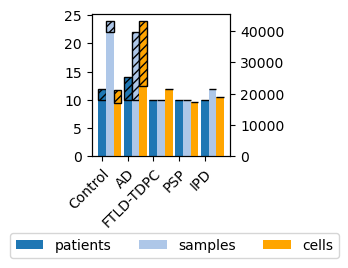

In [121]:
tname=['patients','samples']

x=np.arange(pathOrder.size)
width=0.3
multiplier=1
colors = ['#1f77b4', '#aec7e8']

fig,ax=plt.subplots(figsize=(2.5,2.5),layout='constrained')
ax2 = ax.twinx() 
bars = [] 
for tidx in range(2):
    t=tname[tidx]
    offset=width*multiplier
    bars.append(ax.bar(x+offset,pathPlot[tidx][pathOrderIdx],width,label=t,color=colors[tidx]))
    ax.bar(x+offset,pathPlot_val[tidx],width,bottom=pathPlot[tidx][pathOrderIdx],hatch='////',label=t,color=colors[tidx],edgecolor='k')
    multiplier+=1
    

offset = width * multiplier
bars.append(ax2.bar(x + offset, pathdiagCounts_cells[pathOrderIdx], width, label='cells', color='orange'))
ax2.bar(x + offset, pathdiagCounts_cells_val, width,bottom=pathdiagCounts_cells[pathOrderIdx],hatch='////',edgecolor='k', label='cells', color='orange')

ax.set_xticks(x+width,pathOrder)
ymax = ax.get_ylim()[1]
ax.set_yticks(np.linspace(0, 25, num=6))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
fig.legend(handles=bars, labels=['patients','samples','cells'], loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=True)

# ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('/data/xzhang/neuro/processed/sampleCounts.pdf')

In [125]:
np.sum(finalPartition=='-1')/finalPartition.size

0.21054034656003282

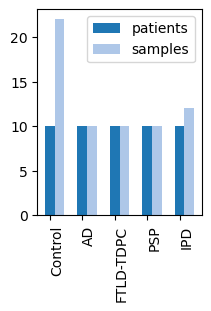

In [12]:
tname=['patients','samples']

x=np.arange(pathOrder.size)
width=0.3
multiplier=1
colors = ['#1f77b4', '#aec7e8']

fig,ax=plt.subplots(figsize=(2,3),layout='constrained')
for tidx in range(2):
    t=tname[tidx]
    offset=width*multiplier
    bars=ax.bar(x+offset,pathPlot[tidx][pathOrderIdx],width,label=t,color=colors[tidx])
    multiplier+=1
ax.set_xticks(x+width,pathOrder)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
ax.legend(loc='upper right')
# plt.savefig('/media/xinyi/T7 Shield/neuro/processed/sampleCounts.pdf')

In [44]:
annoUsed 

array(['AAO', 'AAD', 'Duration', 'Gender', 'Clinical Diag', 'Path Diag',
       'Brain Weight', 'Mutations', 'APOE', 'Braak Tau', 'Thal Phase',
       'CERAD', 'CAA', 'SVD', 'alpha-syn', 'TDP43'], dtype='<U13')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

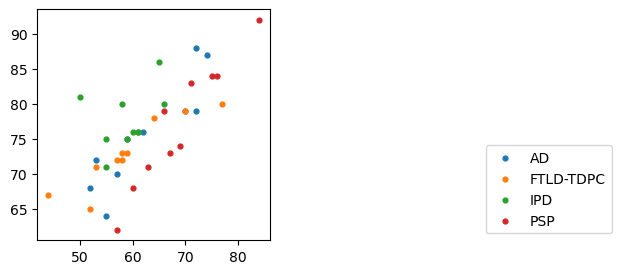

In [97]:
fig, ax = plt.subplots(figsize=(3,3))
path=meta.loc[np.unique(allPatientID)]['Path Diag'][x!='na']
for pidx in range(np.unique(path).size):
    x=meta.loc[np.unique(allPatientID)]['AAO']
    y=meta.loc[np.unique(allPatientID)]['AAD']

    plt.scatter(x[x!='na'].astype(int)[path==np.unique(path)[pidx]],y[x!='na'][path==np.unique(path)[pidx]],s=12,c=plt.cm.tab10.colors[pidx],label=np.unique(path)[pidx])
plt.legend(loc='lower right',bbox_to_anchor=(2.5, 0))
plt.tight_layout()
plt.savefig('/data/xzhang/neuro/processed/aao_aad.pdf')